In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
plt.style.use(["science", "notebook", "grid"])

In [2]:
import sys

In [3]:
sys.path.append('./emdp')

In [4]:
%config Completer.use_jedi = False

In [5]:
sys.path

['/Users/swagatam/Desktop/misc/rl',
 '/usr/local/Cellar/python@3.8/3.8.9/Frameworks/Python.framework/Versions/3.8/lib/python38.zip',
 '/usr/local/Cellar/python@3.8/3.8.9/Frameworks/Python.framework/Versions/3.8/lib/python3.8',
 '/usr/local/Cellar/python@3.8/3.8.9/Frameworks/Python.framework/Versions/3.8/lib/python3.8/lib-dynload',
 '',
 '/Users/swagatam/Library/Python/3.8/lib/python/site-packages',
 '/usr/local/lib/python3.8/site-packages',
 '/usr/local/lib/python3.8/site-packages/IPython/extensions',
 '/Users/swagatam/.ipython',
 './emdp']

### Exploring gridworld code from this repo: https://github.com/zafarali/emdp

`mdp.current_state` = one hot representation of state vector

`mdp.human_state` = (x, y) coordinate of current_state of the agent!

In [6]:
import emdp.gridworld as gw
from emdp.gridworld import build_simple_grid
from emdp.gridworld.builder_tools import create_reward_matrix
from emdp import actions
from emdp.gridworld import GridWorldPlotter
from emdp.analytic import calculate_V_pi

In [8]:
def build_SB_example41():
    
    """
    There are four actions possible in each state, A = {up, down, right, left}, which deterministically cause the
    corresponding state transitions, except that actions that would take the agent off the grid in fact leave the
    state unchanged.
    This is an undiscounted, episodic task. 
    The reward is -1 on all transitions until the terminal state is reached.
    The terminal state is shaded in the figure (although it is shown in two places, it is formally one state).
    """
    size = 4
    gamma = 1      # undiscounted episodic task
    p_success = 1  # actions always successful
    
    
    # on entering any of these states, the mdp inadvertently makes a 
    # last transition to the absorbing states and stays there forever.
    reward_spec = {(0, 0): 0, (size-1, size-1): 0}
    
    P = build_simple_grid(size=size, terminal_states=reward_spec.keys(), p_success=p_success)
    R = create_reward_matrix(P.shape[0], size, reward_spec, action_space=4)
    R += -1        # set all transitions to -1 as create_reward_matrix initializes to 0
    R[0, :] = 0
    R[15, :] = 0
    R[16, :] = 0   # also set the created absorbing state's reward to 0
    #print(R)
    
    # note: terminal/absorbing states can't be the starting state!
    num_terminal_states = len(reward_spec.keys()) + 1  # add 1 for constructed absorbing state
    p0 = np.ones(P.shape[0])
    p0[0] = 0
    p0[15] = 0
    p0[16] = 0
    p0 = p0/(P.shape[0]-num_terminal_states)  # uniform starting probability (assumed)
    
    return gw.GridWorldMDP(P, R, gamma, p0, terminal_states=reward_spec.keys(), size=size)

### more generalised

Q. Why add an extra absorbing state?
- Episodic tasks (have terminal states and eventually interaction ends) and continuing tasks have different return expressions. **[From the book]** _These two can be unified by considering episode termination to be the entering of a special absorbing state that transitions only to itself and that generates only rewards of zero._

In [233]:
def build_SB_example41(size=4):
    
    """
    There are four actions possible in each state, A = {up, down, right, left}, which deterministically cause the
    corresponding state transitions, except that actions that would take the agent off the grid in fact leave the
    state unchanged.
    This is an undiscounted, episodic task. 
    The reward is -1 on all transitions until the terminal state is reached.
    The terminal state is shaded in the figure (although it is shown in two places, it is formally one state).
    
    note on reward_spec/terminal_states:
    ------------------------------------
    On entering any of these states, the mdp inadvertently makes a last transition to the absorbing state and stays
    there forever. (Ref: SB Section 3.4)
    In this question, all transitions get -1 as reward except those last ones from terminal states which has 
    0 reward. Also in absorbing state, all actions receive 0 reward by definition of an episodic task.
    """
    size = size
    gamma = 1                # undiscounted episodic task
    p_success = 1            # actions always successful
    
    reward_spec = {(0, 0): 1, (size-1, size-1): 1}
    
    P = build_simple_grid(size=size, terminal_states=reward_spec.keys(), p_success=p_success)
    R = create_reward_matrix(P.shape[0], size, reward_spec, action_space=4)
    #print(f"R.shape={R.shape}")
    R += -1                  # makes rewards for all transitions -1, except from terminal states
    R[P.shape[0]-1, :] = 0   # also set the constructed dummy absorbing state's reward to 0
    #print(R)
    
    num_terminal_states = len(reward_spec.keys()) + 1
    
    # assumption: terminal/absorbing states can't be the starting state!
    p0 = np.ones(P.shape[0])
    for t in reward_spec:
        #print(f"t={t}")
        p0[size * t[0] + t[1]] = 0
        
    p0[size * size] = 0     # also set dummy absorbing state to zero
    p0 = p0 / (P.shape[0] - num_terminal_states)
    
    return gw.GridWorldMDP(P, R, gamma, p0, terminal_states=reward_spec.keys(), size=size)

In [234]:
build_SB_example41().p0

array([0.        , 0.07142857, 0.07142857, 0.07142857, 0.07142857,
       0.07142857, 0.07142857, 0.07142857, 0.07142857, 0.07142857,
       0.07142857, 0.07142857, 0.07142857, 0.07142857, 0.07142857,
       0.        , 0.        ])

In [235]:
mdp = build_SB_example41()
# state, reward, done, _ = mdp.step(actions.UP) # moves the agent up.

In [236]:
mdp.terminal_states, mdp.current_state, mdp.human_state, mdp.gamma, mdp.done, mdp.has_absorbing_state

([0, 15],
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 (2, 1),
 1,
 False,
 True)

In [237]:
# current_state = one hot representation of state vector
# human_state = (x, y) coordinate of current_state of the agent!

In [238]:
mdp.p0

array([0.        , 0.07142857, 0.07142857, 0.07142857, 0.07142857,
       0.07142857, 0.07142857, 0.07142857, 0.07142857, 0.07142857,
       0.07142857, 0.07142857, 0.07142857, 0.07142857, 0.07142857,
       0.        , 0.        ])

In [239]:
mdp.P.shape

(17, 4, 17)

## build and simulate sample trajectories from a 10x10 gw

In [240]:
mdp = build_SB_example41(10)
mdp.terminal_states, mdp.gamma, mdp.human_state, mdp.done, mdp.has_absorbing_state

([0, 99], 1, (2, 7), False, True)

In [241]:
gwp = GridWorldPlotter(mdp.size, mdp.has_absorbing_state) # alternatively you can use GridWorldPlotter.from_mdp(mdp)

# collect/sample some trajectories from the GridWorldMDP object:

trajectories = []
for _ in range(1000): # 1000 trajectories
    trajectory = [mdp.reset()]
#     trajectory = [mdp.current_state]
#     for _ in range(100): # 10 steps maximum
    while(1):
        state, reward, done, info = mdp.step(random.sample([actions.LEFT, actions.RIGHT, 
                                                        actions.UP, actions.DOWN], 1)[0])
        trajectory.append(state)
        if done:
            trajectory= trajectory[:-1] # whichever terminal state it hits, it moves to (0, 0). so remove last
            break
    trajectories.append(trajectory)

In [242]:
len(trajectories[2])

291

<AxesSubplot:xlabel='x', ylabel='y'>

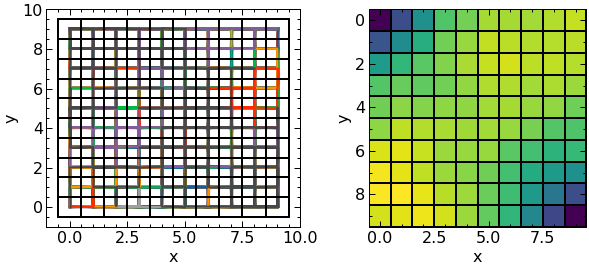

In [243]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121)

# trajectory
gwp.plot_trajectories(ax, trajectories)
gwp.plot_grid(ax)

# heatmap
ax = fig.add_subplot(122)
gwp.plot_heatmap(ax, trajectories)
gwp.plot_grid(ax)

Note how the movement of the agent dips quickly near the terminal states. It is indeed the expected behaviour in
this gridworld.

In [244]:
mdp.terminal_states

[0, 99]

## test $V_\pi$ solution for $\pi$ = equiprobable random policy on a 4x4 gw

In [245]:
mdp = build_SB_example41()
mdp.size, mdp.terminal_states, mdp.gamma, mdp.human_state, mdp.done, mdp.has_absorbing_state

(4, [0, 15], 1, (1, 3), False, True)

In [246]:
# random policy:
policy = np.ones((mdp.P.shape[0], mdp.P.shape[1]))/mdp.P.shape[1]

In [247]:
policy

array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])

use analytic solution provided.
make sure to **remove** the added absorbing state i.e., take only the original (size x size) states

In [248]:
V_pi = calculate_V_pi(mdp.P[:-1, ..., :-1], mdp.R[:-1, ...], policy[:-1, ...], mdp.gamma)

In [249]:
V_pi.reshape(mdp.size, mdp.size)

array([[  0., -14., -20., -22.],
       [-14., -18., -20., -20.],
       [-20., -20., -18., -14.],
       [-22., -20., -14.,   0.]])

In [250]:
mdp.P[:-1, ..., :-1].shape

(16, 4, 16)

In [251]:
mdp.size

4